##### Implement two-layer fully connnected neural net

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os
import skimage.io as io
from skimage.transform import resize
sys.path.append('../')
import nn.neural_net as NN
import helpers.histogram_classifier as hc
from imp import reload
import time
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import HTML
css = open('styles/table-style.css').read() #+ open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [29]:
SIZE = 64

In [30]:
classes = pd.read_csv('../data/food-101/meta/top_classes.csv', index_col=0)
class_list = list(classes['class'].unique())

image_names = {}
for c in class_list:
    image_names[c] = np.array(classes[classes['class'] == c]['name'])

In [31]:
train, test = hc.split_data(image_names, 0.85)

In [32]:
X = []
y = []
X_test = []
y_test = []

for i, c in enumerate(class_list):
    for im in train[c]:
        img = io.imread(os.path.join("../data/food-101/top_classes/", c, "", im))
        img = resize(img, (SIZE, SIZE, SIZE, 3))
        X.append(img)
        y.append(i)
    for im in test[c]:
        img = io.imread(os.path.join("../data/food-101/top_classes/", c, "", im))
        img = resize(img, (SIZE, SIZE, SIZE, 3))
        X_test.append(img)
        y_test.append(i)

X = np.array(X)
y = np.array(y)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [33]:
print("X has shape: {}".format(X.shape))
print("y has shape: {}".format(y.shape))
print("X_test has shape: {}".format(X_test.shape))
print("y_test has shape: {}".format(y_test.shape))

X has shape: (10200, 64, 64, 3)
y has shape: (10200,)
X_test has shape: (1800, 64, 64, 3)
y_test has shape: (1800,)


In [34]:
# Get subset of X_train for validation
train_per_class = int(np.floor(0.85 * 1000))
train_subset = int(np.floor(0.85 * train_per_class))

all_indices = np.arange(X.shape[0])
train_indices = []
test_indices = []

for i, c in enumerate(class_list):
    train_indices.append(all_indices[i * train_per_class:(i * train_per_class) + train_subset])
    test_indices.append(all_indices[(i * train_per_class) + train_subset:(i + 1) * train_per_class])
train_indices = np.array(train_indices)
train_indices = train_indices.reshape((train_indices.shape[0] * train_indices.shape[1],))
test_indices = np.array(test_indices)
test_indices = test_indices.reshape((test_indices.shape[0] * test_indices.shape[1],))

In [35]:
%%time
X_train = X[train_indices]
y_train = y[train_indices]
X_val = X[test_indices]
y_val = y[test_indices]

CPU times: user 465 ms, sys: 918 ms, total: 1.38 s
Wall time: 1.41 s


In [36]:
print("X_train has shape: {}".format(X_train.shape))
print("y_train has shape: {}".format(y_train.shape))
print("X_val has shape: {}".format(X_val.shape))
print("y_val has shape: {}".format(y_val.shape))

X_train has shape: (8664, 64, 64, 3)
y_train has shape: (8664,)
X_val has shape: (1536, 64, 64, 3)
y_val has shape: (1536,)


In [38]:
# Reshape the X data
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))

print("X_train has shape: {}".format(X_train.shape))
print("X_test has shape: {}".format(X_test.shape))
print("X_val has shape: {}".format(X_val.shape))

X_train has shape: (8664, 12288)
X_test has shape: (1800, 12288)
X_val has shape: (1536, 12288)


In [39]:
# Subtract the mean image
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image
X_val -= mean_image

In [41]:
# Double check that loss is reasonable
model = NN.TwoLayerNet(64*64*3, 12, 110)
loss, grad = model.loss(X_val, y_val, reg=0)
print(loss)

2.48490662625


In [42]:
-np.log(1/12)

2.4849066497880004

In [43]:
# Increase regularization and see if loss goes up
model = NN.TwoLayerNet(64*64*3, 12, 110)
loss, grad = model.loss(X_val, y_val, reg=1e3)
print(loss)

9.23618052683


In [44]:
# Try and overfit very small portion of data
X_tiny = X_train[:30]
y_tiny = y_train[:30]
model = NN.TwoLayerNet(64*64*3, 12, 110)
stats = model.train(X_tiny, y_tiny, X_tiny, y_tiny, learning_rate=1e-3, learning_rate_decay=1,
        reg=0.0, num_iterations=200, batch_size=200,
        verbose=True)

iteration 0 / 200: loss 2.48490601
iteration 100 / 200: loss 2.39397815


In [45]:
print("Validation accuracy: {}".format((model.predict(X_tiny) == y_tiny).mean()))

Validation accuracy: 1.0


In [50]:
# Try training with small reg and learning rate
model = NN.TwoLayerNet(64*64*3, 12, 110)
stats = model.train(X_train, y_train, X_val, y_val, learning_rate=1e-5, learning_rate_decay=1,
        reg=0.00001, num_iterations=400, batch_size=200,
        verbose=True)

Loss: 2.4849068606215448, Train: 0.085, Val: 0.07291666666666667
Loss: 2.484906749350882, Train: 0.07, Val: 0.07552083333333333
Loss: 2.484907304750608, Train: 0.065, Val: 0.080078125
Loss: 2.484906534668498, Train: 0.11, Val: 0.08528645833333333
Loss: 2.4849067753419494, Train: 0.065, Val: 0.08723958333333333
Loss: 2.4849072056182653, Train: 0.085, Val: 0.083984375
Loss: 2.48490639918384, Train: 0.085, Val: 0.078125
Loss: 2.4849066557195605, Train: 0.075, Val: 0.08138020833333333
Loss: 2.4849066346704083, Train: 0.08, Val: 0.08528645833333333
Loss: 2.4849064307017192, Train: 0.09, Val: 0.08138020833333333


In [54]:
input_size = 64 * 64 * 3
hidden_size = 110
num_classes = 12
max_count = 100

best_net = None # store the best model into this
pest_params = (0, 0, 0)
best_acc = -1

for i in range(max_count):
    lr = 10 ** np.random.uniform(-6, -3)
    reg = 10 ** np.random.uniform(-5, 5)
    lr_dec = 0.90
    model = NN.TwoLayerNet(input_size, hidden_size, num_classes)
    stats = model.train(X_train, y_train, X_val, y_val,
            num_iterations=300, batch_size=200,
            learning_rate=lr, learning_rate_decay=lr_dec,
            reg=reg, verbose=False)
    val_acc = (model.predict(X_val) == y_val).mean()
    if val_acc > best_acc:
        best_net = model
        best_params = (lr, reg, lr_dec)
        best_acc = val_acc
    print("val_acc: {}, lr: {}, reg: {}, lr_dec: {}".format(val_acc, lr, reg, lr_dec))

val_acc: 0.09049479166666667, lr: 1.052639782242061e-06, reg: 742.7246290397305, lr_dec: 0.9
val_acc: 0.08333333333333333, lr: 6.0127700922075686e-05, reg: 37.94839635941657, lr_dec: 0.9
val_acc: 0.08333333333333333, lr: 1.6244766994909238e-05, reg: 0.03037262263598105, lr_dec: 0.9
val_acc: 0.09049479166666667, lr: 5.971062486555303e-06, reg: 0.4954517101918068, lr_dec: 0.9
val_acc: 0.07486979166666667, lr: 1.5452898744736483e-06, reg: 0.002968911979894837, lr_dec: 0.9
val_acc: 0.08723958333333333, lr: 2.862355635566686e-05, reg: 4.155991423306856e-05, lr_dec: 0.9
val_acc: 0.10026041666666667, lr: 8.984798927513066e-06, reg: 0.0002588578506827222, lr_dec: 0.9
val_acc: 0.08333333333333333, lr: 4.438839798728978e-06, reg: 0.0024297511522021835, lr_dec: 0.9
val_acc: 0.08138020833333333, lr: 2.7093673781731677e-06, reg: 0.0005113398220916362, lr_dec: 0.9
val_acc: 0.072265625, lr: 1.35528558798903e-06, reg: 5.552917576070718e-05, lr_dec: 0.9
val_acc: 0.08333333333333333, lr: 7.3750915416650

In [58]:
best_params

(1.3185433957962784e-06, 0.0015940640086333096, 0.9)

In [63]:
input_size = 64 * 64 * 3
hidden_size = 110
num_classes = 12
max_count = 100

best_net = None # store the best model into this
pest_params = (0, 0, 0)
best_acc = -1

for i in range(max_count):
    lr = 10 ** np.random.uniform(-7, -5)
    reg = 10 ** np.random.uniform(-4, 0)
    lr_dec = 0.90
    model = NN.TwoLayerNet(input_size, hidden_size, num_classes)
    stats = model.train(X_train, y_train, X_val, y_val,
            num_iterations=300, batch_size=200,
            learning_rate=lr, learning_rate_decay=lr_dec,
            reg=reg, verbose=False)
    val_acc = (model.predict(X_val) == y_val).mean()
    if val_acc > best_acc:
        best_net = model
        best_params = (lr, reg, lr_dec)
        best_acc = val_acc
    print("val_acc: {}, lr: {}, reg: {}, lr_dec: {}".format(val_acc, lr, reg, lr_dec))

val_acc: 0.07682291666666667, lr: 4.5652994358280407e-07, reg: 0.3924547611129168, lr_dec: 0.9
val_acc: 0.08072916666666667, lr: 8.109903419838734e-07, reg: 0.005022389865903977, lr_dec: 0.9
val_acc: 0.08333333333333333, lr: 3.683736031150013e-06, reg: 0.04908660097389165, lr_dec: 0.9
val_acc: 0.08138020833333333, lr: 3.444935016373524e-07, reg: 0.00013524985200110649, lr_dec: 0.9
val_acc: 0.07552083333333333, lr: 1.3982627388608971e-06, reg: 0.0006826648750741391, lr_dec: 0.9
val_acc: 0.08203125, lr: 2.717324273224199e-06, reg: 0.03525315541841678, lr_dec: 0.9
val_acc: 0.076171875, lr: 1.0356580373275724e-06, reg: 0.006102869138787725, lr_dec: 0.9
val_acc: 0.078125, lr: 9.971807948369419e-06, reg: 0.0015892792428496758, lr_dec: 0.9
val_acc: 0.080078125, lr: 1.0511191100527436e-07, reg: 0.007598230882908969, lr_dec: 0.9
val_acc: 0.07942708333333333, lr: 2.4778532493577255e-06, reg: 0.01749489249747415, lr_dec: 0.9
val_acc: 0.08333333333333333, lr: 2.4808722876942983e-06, reg: 0.0118167

In [66]:
best_params

(2.3107494741916856e-07, 0.13708316142103177, 0.9)

In [94]:
input_size = 64 * 64 * 3
hidden_size = 110
num_classes = 12

lr = 2.3107494741916856e-07
reg = 0.13708316142103177
lr_dec = 0.99

model = NN.TwoLayerNet(input_size, hidden_size, num_classes)
stats = model.train(X_train, y_train, X_val, y_val,
                    num_iterations=4000, batch_size=200,
                    learning_rate=lr, learning_rate_decay=lr_dec, reg=reg, verbose=True)

Loss: 4.700582048303358, Train: 0.01, Val: 0.020833333333333332
Loss: 4.700581303028923, Train: 0.07, Val: 0.078125
Loss: 4.700580637329204, Train: 0.09, Val: 0.10026041666666667
Loss: 4.700579862851477, Train: 0.085, Val: 0.10026041666666667
Loss: 4.700579232931388, Train: 0.065, Val: 0.10026041666666667
Loss: 4.700578572477547, Train: 0.045, Val: 0.10026041666666667
Loss: 4.70057773297555, Train: 0.115, Val: 0.10416666666666667
Loss: 4.700576984685404, Train: 0.1, Val: 0.10677083333333333
Loss: 4.700576441177795, Train: 0.065, Val: 0.10416666666666667
Loss: 4.700575781234439, Train: 0.075, Val: 0.1015625
Loss: 4.700575017460752, Train: 0.105, Val: 0.10286458333333333
Loss: 4.700574328857715, Train: 0.08, Val: 0.103515625
Loss: 4.700573718638539, Train: 0.1, Val: 0.10611979166666667
Loss: 4.700573100993856, Train: 0.085, Val: 0.10546875
Loss: 4.700572500024417, Train: 0.08, Val: 0.10026041666666667
Loss: 4.700571826116328, Train: 0.105, Val: 0.10221354166666667
Loss: 4.700571205332962

In [95]:
(best_net.predict(X_test) == y_test).mean()

0.089444444444444438

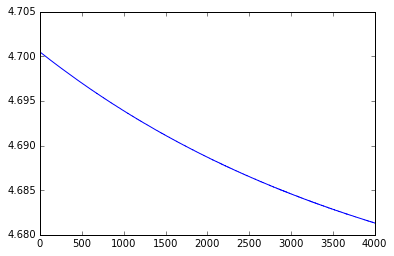

In [87]:
plt.plot(stats["loss_history"])
plt.show()

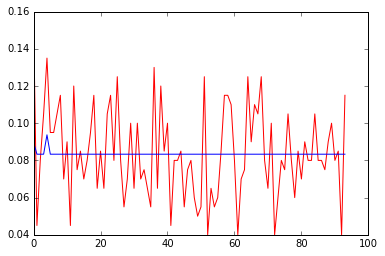

In [88]:
plt.plot(stats["train_acc_history"], color='red')
plt.plot(stats["val_acc_history"], color='blue')
plt.show()